In [19]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [20]:
#Đọc data
df = pd.read_csv('../STB-Historical-Data.csv',index_col=0,parse_dates=True).sort_values(by='Date',ascending=True)
df = df[['Price']]

In [21]:
df

,Price
Date,
2019-01-02,"11,600.0"
2019-01-03,"11,100.0"
2019-01-04,"11,150.0"
2019-01-07,"11,500.0"
2019-01-08,"11,350.0"
...,...
2023-05-26,"27,200.0"
2023-05-29,"27,700.0"
2023-05-30,"27,700.0"


In [22]:
#Xóa dấu , và chuyển về float
df['Price']=df['Price'].replace(',','',regex=True).astype(float)


In [23]:
# 3. Scaler data
scaler=MinMaxScaler()
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [24]:
# 4. Chia train test val theo tỉ lệ 7-2-1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [25]:
# 5. Hàm Create Dataset
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [26]:
#6. Reshape into X=t,t+1,t+2..t+39 and Y=t+40
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [27]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [28]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(40,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [29]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1,shuffle=False)

Epoch 1/100
12/12 [==============================] - 22s 484ms/step - loss: 0.0116 - val_loss: 0.0362
Epoch 2/100
12/12 [==============================] - 1s 106ms/step - loss: 0.0468 - val_loss: 0.0061
Epoch 3/100
12/12 [==============================] - 1s 113ms/step - loss: 0.0353 - val_loss: 0.0167
Epoch 4/100
12/12 [==============================] - 1s 113ms/step - loss: 0.0617 - val_loss: 0.0349
Epoch 5/100
12/12 [==============================] - 1s 116ms/step - loss: 0.0092 - val_loss: 0.0114
Epoch 6/100
12/12 [==============================] - 2s 128ms/step - loss: 0.0112 - val_loss: 0.0052
Epoch 7/100
12/12 [==============================] - 1s 117ms/step - loss: 0.0105 - val_loss: 0.0087
Epoch 8/100
12/12 [==============================] - 1s 124ms/step - loss: 0.0126 - val_loss: 0.0052
Epoch 9/100
12/12 [==============================] - 1s 118ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 10/100
12/12 [==============================] - 1s 117ms/step - loss: 0.0104 - val_l

In [30]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 17ms/step


In [31]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [32]:
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
yval=scaler.inverse_transform(yval.reshape(-1,1))

In [33]:
#Tính độ đo
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(yval))  # MAPE
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(ytest))  # MAPE
valid_mae = mean_absolute_error(y_pred_val,yval) # MAE
test_mae = mean_absolute_error(y_pred,ytest)
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")
print(f"Validation MAE: {valid_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

Validation RMSE: 741.72
Testing RMSE: 1761.77
Validation MAPE: 2.46%
Testing MAPE: 6.41%
Validation MAE: 629.38
Testing MAE: 1329.87


In [34]:
df = pd.read_csv('../STB-Historical-Data.csv',index_col=0,parse_dates=True).sort_values(by='Date',ascending=True)

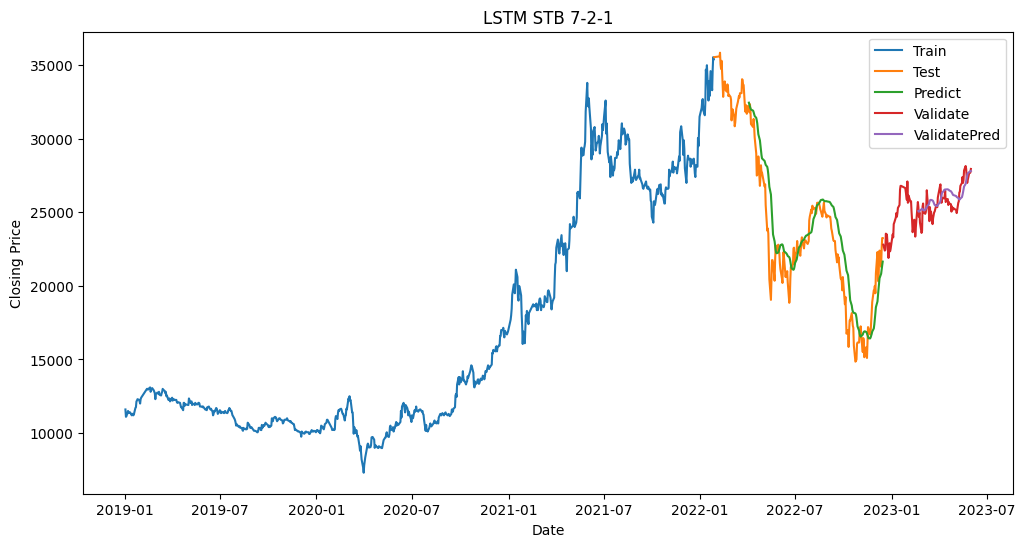

In [35]:
# 14.Vẽ hình
plt.figure(figsize=(12,6))
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('LSTM STB 7-2-1')
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
#prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
#plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()